In [1]:
# Make sure accelerate is installed otherwise the following error may be raised
"""
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. 
Defaulting to `low_cpu_mem_usage=False`. 
It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. 
You can do so with: 
    ```
    pip install accelerate
    ```
"""

import os
import gc
import diffusers
import schedulers
import inspect
import numpy as np
import seaborn as sns
from dataclasses import dataclass
from tqdm.auto import tqdm
from math import ceil

import torch
from torchvision import transforms as tfms

from autoencoders import AutoEncoder, VAE

from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer, logging
from huggingface_hub import notebook_login

from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image

# TODO this will have to be changed for the main.py code
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Supress CLIPTextModel warnings
logging.set_verbosity_error()

c:\Users\diogo\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class StableDiffusionPipeline():

    def __init__(self, prompt, inference_steps, guidance_scale,
                 height=512, width=512,
                 scheduler="LMSDiscreteScheduler", scheduler_params={},
                 seeded_generator=torch.manual_seed(32)):
        self.prompt = prompt
        self.seeded_generator = seeded_generator

        self.inference_steps = inference_steps
        self.guidance_scale = guidance_scale

        self.height = height
        self.width = width

        # Device
        self.initialise_device()

        # Components
        self.initialise_components(scheduler, scheduler_params)
        self.components_to_gpu()

        # Initialise embeddings, scheduler and latents that are required prior to inference
        self.initialise_text_embeddings(self.prompt)
        self.initialise_scheduler()
        self.initialise_latents()

    def initialise_device(self):
        # Set device based on CUDA, MPS (MacOS), CPU
        self.device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

        if "mps" == self.device: 
            os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

    def initialise_components(self, scheduler, scheduler_params):
        # Using the original scheduler was suboptimal and they created their own cosine scheduler which gave much better improvements
        self.scheduler = self.select_scheduler(scheduler, scheduler_params)
        
        # Load the autoencoder model which will be used to decode the latents into image space.
        self.vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
        # # Loading a previously trained model using autoencoders.py
        # state_dict = torch.load("../training/saved_models/vae.pth")
        # # Load the state_dict into the model
        # self.vae = VAE()
        # self.vae.load_state_dict(state_dict)
        # # Make sure that we set the model to evaluation mode to make sure that the running statistics that were calculated in batch normalisation
        # # are consistent during inference
        # self.vae.eval()

        # The UNet model for generating the latents.
        self.unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")
        
        # Load the tokeniser and text encoder to tokenize and encode the text.
        # CLIP uses a ViT like transformer that gets visual features and a causal language model for the text features
        # Both the text and visual features are proejcted into a latent space with  identical dimensions and a dot product between the projected image and the text features is used as a similarity score
        # Images are split into fixed-size and non overlapping sequendes called patches - positional embeddings are also added.
        # If needed images can be resized and normalised using the CLIPImageProcessor
        # The CLIPTokeniser encodes the text
        self.tokeniser = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
        self.text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")


    def select_scheduler(self, scheduler_type: str, scheduler_params: dict=None):
        # Try to get the scheduler from the diffusers library
        try:
            SchedulerClass = getattr(diffusers, scheduler_type)
        except AttributeError:
            try:
                # If it is not in the diffusers library then we can check our schedulers module that uses the SchedulerMixin
                SchedulerClass = getattr(schedulers, scheduler_type)
            except AttributeError:
                print(self.get_custom_schedulers())
                raise AttributeError(f"The following scheduler {scheduler_type} does not exist in the diffusers library or in the scheduler file.\n The following are possible choices in the diffusers library:\n{self.get_diffusers_schedulers()}")


        self.validate_scheduler_params(SchedulerClass, scheduler_params)
        # Instantiate the scheduler with the provided parameters - make sure that your parameters that you pass in match the requirements
        return SchedulerClass(**scheduler_params)

    def validate_scheduler_params(self, scheduler_class, scheduler_params):
        # Get the __init__ method of the scheduler class
        init_signature = inspect.signature(scheduler_class.__init__)
        
        # Get the parameter names (excluding 'self')
        valid_params = [param for param in init_signature.parameters if param != 'self']

        # Identify invalid parameters
        invalid_params = [param for param in scheduler_params if param not in valid_params]

        if invalid_params:
            print(f"Error: Invalid parameters {invalid_params} for {scheduler_class.__name__}.")
            print(f"Expected parameters are: {valid_params}")
            return False
        return True

    def get_diffusers_schedulers(self):
        # We can use the inspect module if we get all the members of the diffusers module and we check if it ends with Scheduler
        return [name for name, obj in inspect.getmembers(diffusers) if inspect.isclass(obj) and name.endswith('DiscreteScheduler')]
    
    def get_custom_schedulers(self):
        # We can use the inspect module if we get all the members of the diffusers module and we check if it ends with Scheduler
        return [name for name, obj in inspect.getmembers(schedulers) if inspect.isclass(obj) and name.endswith('Scheduler')]

    def components_to_gpu(self):
        # Move the initialised components to the gpu
        self.vae = self.vae.to(self.device)
        self.text_encoder = self.text_encoder.to(self.device)
        self.unet = self.unet.to(self.device)

    def initialise_text_embeddings(self, prompt):
        # Conditioned text embeddings
        self.prompt_tokens = self.tokeniser(prompt, padding="max_length", max_length=self.tokeniser.model_max_length, truncation=True, return_tensors="pt")
        with torch.no_grad():
            # text_embeddings = self.text_encoder(text_input.input_ids.to(self.device))[0]
            text_embeddings = self.get_embeddings(self.prompt_tokens.input_ids.to(self.device))
        
        # Matching the conditioned max max length and creating the unconditioned embeddings
        max_length = self.prompt_tokens.input_ids.shape[-1]
        uncond_input = self.tokeniser([""], padding="max_length", max_length=max_length, return_tensors="pt")
        with torch.no_grad():
            uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(self.device))[0]

        # Concatenate both
        self.text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    def visualise_tokenisation(self, show_tensor=True, show_attention_mask=True):
        # Starts off with a prompt - then we tokenise it into a series of tokens using our CLIPTokeniser
        # This tokeniser makes sure it is padded
        printed_tokens = set()

        if show_tensor or show_attention_mask:
            if show_tensor:
                print(f"Tokenised text tensor:\n{self.prompt_tokens['input_ids'][0]}\n")
            if show_attention_mask:
                print(f"Tokenised text tensor:\n{self.prompt_tokens['attention_mask'][0]}\n")
        else:
            print("For the sake of clarity the padded tokens and the attention mask are removed from the output, run this method with show_tensor=True and/or attention_mask=True to see them respectively.\n")

        # See the individual tokens
        for token in self.prompt_tokens['input_ids'][0]:
            token_value = int(token)
            if token_value not in printed_tokens:
                print(f"Token: {token} - Value: {self.tokeniser.decoder.get(token_value)}")
                printed_tokens.add(token_value)

    def build_causal_attention_mask(self, bsz, seq_len, dtype):
        # lazily create causal attention mask, with full attention between the vision tokens
        # pytorch uses additive attention mask; fill with -inf
        mask = torch.empty(bsz, seq_len, seq_len, dtype=dtype)
        mask.fill_(torch.tensor(torch.finfo(dtype).min))
        mask.triu_(1)  # zero out the lower diagonal
        mask = mask.unsqueeze(1)  # expand mask
        return mask

    def get_embeddings(self, input_embeddings):
        # TODO undestand code and comment it
        token_embeddings = self.text_encoder.text_model.embeddings.token_embedding(input_embeddings)
        # TODO why only 77
        position_ids = self.text_encoder.text_model.embeddings.position_ids[:, :77]
        positional_embeddings = self.text_encoder.text_model.embeddings.position_embedding(position_ids)

        embedding = token_embeddings + positional_embeddings

        # CLIP's text model uses causal mask, so we prepare it here:
        bsz, seq_len = embedding.shape[:2]
        causal_attention_mask = self.build_causal_attention_mask(bsz, seq_len, embedding.dtype)

        # Getting the output embeddings involves calling the model with passing output_hidden_states=True
        # so that it doesn't just return the pooled final predictions:
        encoder_outputs = self.text_encoder.text_model.encoder(
            inputs_embeds=embedding,
            attention_mask=None,
            causal_attention_mask=causal_attention_mask.to(self.device),
            output_attentions=None,
            output_hidden_states=True,
            return_dict=None,
        )

        # We're interested in the output hidden state only
        output = encoder_outputs[0]

        # There is a final layer norm we need to pass these through
        output = self.text_encoder.text_model.final_layer_norm(output)
        return output

    def initialise_scheduler(self):
        # The timesteps - betas that we define are values that are between 0 and 1 and change how the distribution is changed
        # When we initially start with a beta value of 0 it starts off with the image that we started with and 0 noise applied
        # It makes sense to scale the variance (the amount of noise that we add) however we must make sure that we also vary the 
        # mean of the image being added - we have to make sure that as the variance grows we scale the mean down by 
        # roo(1 - beta) so that our distribution remains and our pure white noise at the end of our sampling is a standard normal distribution
        self.scheduler.set_timesteps(self.inference_steps)
        self.scheduler.timesteps = self.scheduler.timesteps.to(torch.float32)

    def visualise_scheduler(self, scheduler=None, timesteps=None):
        # TODO figure out how scheduler.scale_model_input works and what it does (what scaling / pre conditioning is)
        if not scheduler:
            scheduler = self.scheduler

        if timesteps:
            scheduler.set_timesteps(timesteps)

        # Visualising the sigmas (the amount of noise) that the scheduler will choose to add to our latents
        plt.plot(scheduler.sigmas)
        plt.title('Noise Schedule')
        plt.xlabel('Steps')
        plt.ylabel('Sigma')
        plt.show()

    def visualise_timestep_embeddings(self):
        _, ax = plt.subplots(1, 1, figsize=(8,6))
        sns.heatmap(self.scheduler.timesteps, cmap='bwr', ax=ax)
        ax.set_xlabel('Embedding Dimension')
        ax.set_ylabel('Timestep')
        plt.show()

    def visualise_noised_latents(self, latents, scheduler, timesteps):
        max_timesteps = len(scheduler.timesteps)
        assert timesteps < max_timesteps, "The timestep chosen to visualise the noised image must be lower than the current max {max_timesteps}"

        noise = torch.rand_like(latents)
        # This add noise function is the same noised_sample = original + noise * sigmas
        encoded_and_noised = scheduler.add_noise(latents, noise, timesteps=torch.tensor([scheduler.timesteps[timesteps]]))
        decoded_latents = self.decode_latents(encoded_and_noised.float().to("cuda"))
        plt.imshow(self.scale_image(decoded_latents))

    def initialise_latents(self):
        # Prep latents - our latents are 64x smaller so we generate the noise in the latent dimension
        # We can generate an object by sampling white noise from a standard normal distribution adn then iteratively sampling x_t-1
        self.latents = torch.randn(
            (1, self.unet.config.in_channels, self.height // 8, self.width // 8),
            generator=self.seeded_generator,
        )
        self.latents = self.latents.to(self.device)
        self.latents = self.latents * self.scheduler.init_noise_sigma

    def update_prompt(self, prompt):
        self.prompt = prompt
        self.initialise_text_embeddings(self.prompt)

    def image_to_latents(self, image):
        # Output the latents of a single image
        with torch.no_grad():
            latent = self.vae.encode(tfms.ToTensor()(image).unsqueeze(0).to(self.device)*2-1) # Note scaling
        images = 0.18215 * latent.latent_dist.sample()
        images = images.to("cpu")
        self.display_images(np.array(images[0]), 4, cmap="gray")
        return images

    def decode_latents(self, latents):
        latents = 1 / 0.18215 * latents
        with torch.no_grad():
            return self.vae.decode(latents).sample

    def scale_image(self, image):
        # The scaling that was originally applied to the image is reversed so we send the -1 to 1 to 0 to 1 and it is clamped to that region
        # Then we take it to the CPU and change its dimensions so that it can be used by PIL and pyplot - make sure its a numppy array too
        # Then we scale from 0 to 255 from the 0 to 1 range
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
        image = (image * 255).round().astype("uint8")
        return Image.fromarray(image[0])

    def show_generated_image(self):
        plt.imshow(self.image)

    def display_images(self, images, cols=1, **kwargs):
        num_images = len(images)
        rows = ceil(num_images / cols)

        # Create subplots and flatten it so that we get an easy iterable
        _, axs = plt.subplots(rows, cols, figsize=(15, 5*rows))
        axs = axs.flatten()
        
        # Iterate through the images and plot them - making sure to turn off the axis
        for i, image in enumerate(images):
            axs[i].imshow(image, **kwargs)
            axs[i].axis('off')

        # We can use the remainder of the i variable to hide any unused subplots
        for j in range(i + 1, len(axs)):
            axs[j].axis('off')

        # Adjust layout to prevent overlapping
        plt.tight_layout()
        plt.show()

    def show_gpu_usage():
        if torch.cuda.is_available():
            megabyte = 1024 ** 2
            gpu_memory_allocated = torch.cuda.memory_allocated(0) / megabyte
            gpu_memory_reserved = torch.cuda.memory_reserved(0) / megabyte
            print(f"Memory Allocated: {gpu_memory_allocated:.2f} MB")
            print(f"Memory Reserved: {gpu_memory_reserved:.2f} MB")
        else:
            print("CUDA is not currently in use.")

    def clear_cuda(self):
        # Clearing CUDA so that it does not run out of memory during multiple instantiations - big problem especially in notebooks
        torch.cuda.synchronize()
        gc.collect()
        torch.cuda.empty_cache()

    def generate(self, show=True):
        """
        DDPM Sampling
        First sample x_t from a normal distribution - if we are doing this conditioned then do 2 * those latents
        Making sure that we scale the input based on the noise being added / sampled
        Then we iteratively:
            Use the unet to predict then noise and if we doubled it then we have to unchunk into the conditional and unconditional noise predictions
            Scale them based on guidance scale
            Step with the scheduler using our noise prediction, timestep and the current latents that we have
                If t == 1 then we dont want to add the noise back when stepping as we are done
        Decode with the VAE
        """

        # with autocast("cuda"): # This is useful but locally my 1650ti notebook version gets a mixed precision error so I've had to turn it off
        for _, t in tqdm(enumerate(self.scheduler.timesteps), total=len(self.scheduler.timesteps)):
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([self.latents] * 2)

            # By preconditioning or scaling the latents we are ensuring that we are improving the stability and performance of the model by compensating for the different noise levels
            # and adjusting the variability of the magnitude of the inputs as the sigma will always be chosen by the scheduler
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

            # Predict the noise residual
            with torch.no_grad():
                # The encoder hidden states in the unet is the encoded text embeddings that CLIP provides that will guide the model
                noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=self.text_embeddings).sample

            # Guidance - we initially combined the two text embeddings and concatenated two latents to do the conditioned and unconditioned together
            # Use .chunk to split the noise prediction of the two concatenated tensors into the unconditioned noise prediction
            # and the conditioned on text noise prediction, these are then updated using the guidance scale formula
            # Take the difference between the conditioned and the unconditioned noise - the higher the guidance scale the more we follow the conditioned noise
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + self.guidance_scale * (noise_pred_text - noise_pred_uncond)

            # Here we are essentially sampling from the posterior distribution in order to remove the noise
            self.latents = self.scheduler.step(noise_pred, t, self.latents).prev_sample

        self.image = self.decode_latents(self.latents)
        self.image = self.scale_image(self.image)
        if show == True:
            self.show_generated_image()

        # self.clear_cuda()

        return self.image
        

100%|██████████| 50/50 [26:42<00:00, 32.04s/it]


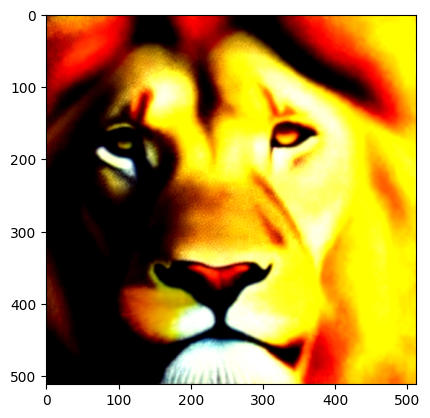

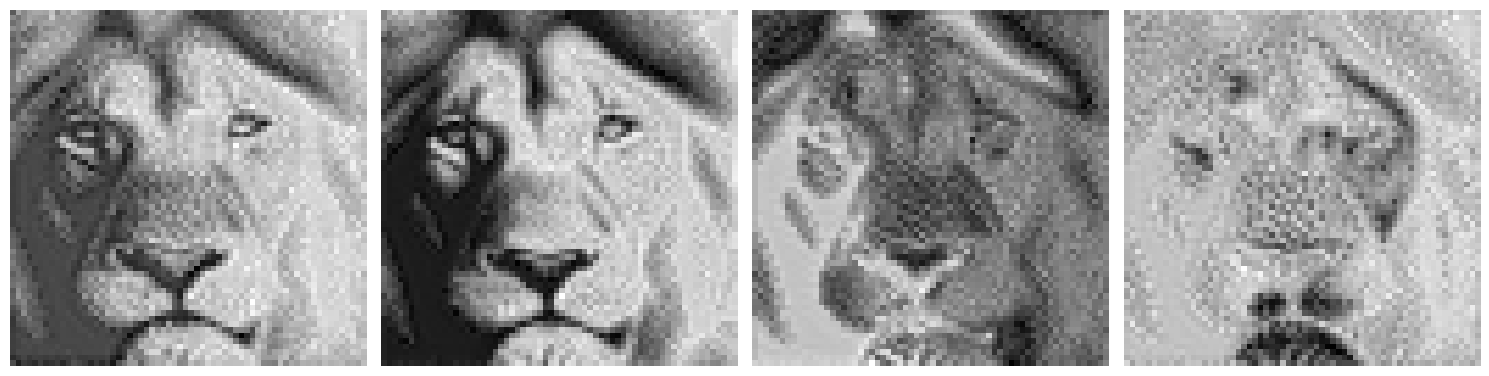

Tokenised text tensor:
tensor([49406,   320,  5302, 12609,  5567, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407])

Tokenised text tensor:
tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0])

Token: 49406 - Value: <|startoftext|>
Token: 320 - Value: a</w>
Token: 5302 - Value:

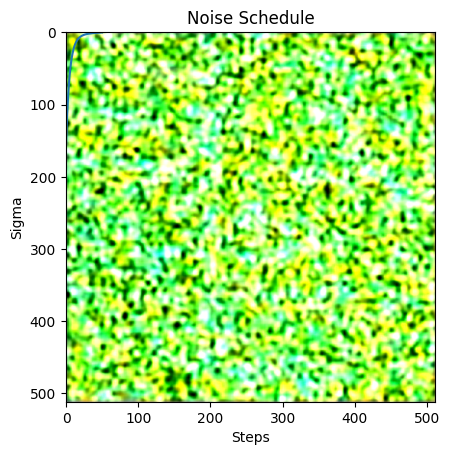

['EulerAncestralDiscreteScheduler',
 'EulerDiscreteScheduler',
 'FlaxEulerDiscreteScheduler',
 'FlaxLMSDiscreteScheduler',
 'FlowMatchEulerDiscreteScheduler',
 'FlowMatchHeunDiscreteScheduler',
 'HeunDiscreteScheduler',
 'KDPM2AncestralDiscreteScheduler',
 'KDPM2DiscreteScheduler',
 'LMSDiscreteScheduler']

In [5]:
prompt = "A highly detailed lion"
height = 512                               
width = 512                                 
inference_steps = 50                       
guidance_scale = 7.5 
seeded_generator = torch.manual_seed(65)

# Use pipeline.get_diffusers_schedulers() to get all other possible types
scheduler = "LMSDiscreteScheduler"
scheduler_params = {
    "beta_start": 0.00085,
    "beta_end": 0.012,
    "beta_schedule": "scaled_linear",
    "num_train_timesteps": 1000
}

# Generating an image and the visualising its latents
pipeline = StableDiffusionPipeline(prompt, inference_steps, guidance_scale, scheduler=scheduler, scheduler_params={})
image = pipeline.generate(show=True)

# You can use any image here - Only limit is the resolution has to be factors of 8
latents = pipeline.image_to_latents(image)
pipeline.visualise_noised_latents(latents, pipeline.scheduler, 5)
pipeline.visualise_tokenisation(show_tensor=True, show_attention_mask=True)
pipeline.visualise_scheduler()
pipeline.get_diffusers_schedulers()

In [1]:
"""
Paper Notes

Definitions:
beta - e.g using a linear schedule in this case (applies to all other schedules)
beta against time linearly increases - we scale the variance (noise forward) a lot more whilst scaling down the image mean

alpha - 1 - beta

alpha_hat - is the cumulative product of all alphas
"""

"""
Forward process:
Using the reparameterisation trick - where here the epsilon is the standard normal distribution
Sampling from that normal distribution is equivalent to root(1 - beta) * x_t-1 = root(beta) * epsilon

We can rewrite this using alpha
root(alpha) * x_t-1 = root(1 - alpha) * epsilon

Extending this to earlier timesteps - we can chain the alphas
root(alpha_t * alpha_t-1) * x_t-2 = root(1 - alpha_t * alpha_t-1) * epsilon

This can go all the way to the beginning and hence why we have cumulative alphas
This is the formula for the forward diffusion process which we can use during training
root(alpha_hat) * x_0 = root(1 - alpha_hat) * epsilon
"""

"""
Loss Function:

Negative log likelihood
However the probability of x_0 requires you predicting all other timesteps and keeping track of t-1 other random variables

We can instead compute the lower bound which is always smaller - Variational Lower Bound
This involves simplifying the KL Divergence that we can add to regularise but also cancels out the log likelihood which is intractable
||epsilon - epsilon_theta(x_t, t)||^2

Predicted noise based on the image at timestep t and the actual timestep
"""

'\nPaper Notes\n\nDefinitions:\nbeta - e.g using a linear schedule in this case (applies to all other schedules)\nbeta against time linearly increases - we scale the variance (noise forward) a lot more whilst scaling down the image mean\n\nalpha - 1 - beta\n\nalpha_hat - is the cumulative product of all alphas\n\nForward process:\nUsing the reparameterisation trick - where here the epsilon is the standard normal distribution\nSampling from that normal distribution is equivalent to root(1 - beta) * x_t-1 = root(beta) * epsilon\n\nWe can rewrite this using alpha\nroot(alpha) * x_t-1 = root(1 - alpha) * epsilon\n\nExtending this to earlier timesteps - we can chain the alphas\nroot(alpha_t * alpha_t-1) * x_t-2 = root(1 - alpha_t * alpha_t-1) * epsilon\n\nThis can go all the way to the beginning and hence why we have cumulative alphas\nThis is the formula for the forward diffusion process which we can use during training\nroot(alpha_hat) * x_0 = root(1 - alpha_hat) * epsilon\n'